In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import os
import wfdb
from tqdm import tqdm

## Initialisation

In [65]:
min_heartrate_expected = 30 # TODO potentially change this
sample_frequency = 500
min_RR_interval_length = 60/min_heartrate_expected
max_sample_length = sample_frequency * 5 * min_RR_interval_length 
no_classes = 3

max_sample_length = 18286

## Convolutional Block

In [66]:
def convolutional_block(x, filter, rate, pool=False):
    
    # copy tensor to variable called x_skip
    x_skip = x
    if pool: x_skip = tf.keras.layers.MaxPool1D()(x_skip)
    
    x = tf.keras.layers.BatchNormalization()(x) #TODO check axis here
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.Conv1D(filter, 15, padding='same', strides=(1))(x) # TODO change hyperparameters here
    if pool: x = tf.keras.layers.AveragePooling1D()(x)
    
    # add residue TODO potentially do this better with connections between multiple layers 
    x = tf.keras.layers.Add()([x, x_skip])     
    
    return x

## Total model build

In [67]:
def NNN(shape = (max_sample_length, 1), classes = 3):
    
    # Setup Input Layer
    x_input = tf.keras.layers.Input(shape)
    # x = tf.keras.layers.ZeroPadding1D()(x_input) # TODO check if this padding is neccessary
    x = x_input
    
    # Define initial filter size
    filter_size = 15
    dropout_rate = 0.01
    
    # Build 16 convolutional blocks
    for i in range(16):
        # The filter size will go on increasing by a factor of 2
        filter_size = 1
        x = convolutional_block(x, filter_size, dropout_rate, pool = (i%3 == 0)) # only pool one in every 3 layers
    
    # End Dense Network
    n_dense_parameters = 32
    x = tf.keras.layers.Flatten()(x) # TODO check if this is neccessary
    x = tf.keras.layers.Dense(n_dense_parameters, activation='relu')(x) # optimise over this n_dense_parameters variable
    x = tf.keras.layers.Dense(classes, activation='softmax')(x) 
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="NNNet")
    return model

In [68]:
model = NNN()

In [69]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Prepare the data for training

In [70]:
from utils.metadata import find_maximum_time_length_of_sample_in_dataset
import pandas as pd

In [71]:
dataset_path = "2_data\\physionet_datasets\\training2017"

file_list = [file_ for file_ in os.listdir(dataset_path) if file_.endswith('.mat')]

# frequence_of_samples = wfdb.rdrecord(os.path.join(dataset_path, file_list[0].split('.mat',2)[0]), channels=[0]).fs
# maximum_length_of_samples = int(find_maximum_time_length_of_sample_in_dataset(dataset_path) * frequence_of_samples)
# maximum_length_of_samples

In [72]:
%store -r maximum_length_of_samples

In [73]:
# data = np.zeros((len(file_list), int(maximum_length_of_samples)))
# for i, file in tqdm(enumerate(file_list)):
#     x = wfdb.rdrecord(os.path.join(dataset_path,file.split('.mat',2)[0]), channels=[0]).p_signal
#     data[i][:x.shape[0]] = np.squeeze(x) 
# np.save(f"{dataset_path}\\2017\\entire_dataset", np.array(data))

In [74]:
ecg_data = np.load(f"{dataset_path}\\2017\\entire_dataset.npy", allow_pickle=True)
label_file = os.path.join(dataset_path, "REFERENCE.csv")
labels = pd.read_csv(label_file, header = None, names = ['name', 'label']).to_numpy()
ecg_data.shape, labels.shape

((8528, 18286), (8528, 2))

### Remove noisy samples

In [75]:
indices_no_noise = [i for i,label in enumerate(labels[:,1]) if label != '~']
ecg_data_no_noise = ecg_data[indices_no_noise]
labels_no_noise = labels[indices_no_noise]
len(indices_no_noise)

8244

### Encode the labels

In [76]:
encoded_labels = np.zeros((len(indices_no_noise)), dtype=object)

def generate_encoded_label(label):
    if 'N' == label: return 0
    elif 'A' == label: return 1
    elif 'O' == label: return 2
    else: raise ValueError('Label given does not match any known label')

    
for i,label in tqdm(enumerate(labels_no_noise[:,1])):
    encoded_labels[i] = generate_encoded_label(label)
        
from keras.utils import to_categorical
categorical_labels = to_categorical(encoded_labels, num_classes=3)
categorical_labels

8244it [00:00, 1177318.43it/s]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Compile and Train the model

In [77]:
model.compile(optimizer='adam', loss='categorical_crossentropy') # TODO experiment with loss and optimizers

In [78]:
train_proportion = 0.8
train_indice = int(0.8*ecg_data_no_noise.shape[0])
x_train = np.expand_dims(ecg_data_no_noise[:train_indice],2)
y_train = categorical_labels[:train_indice]
x_test = np.expand_dims(ecg_data_no_noise[train_indice:],2)
y_test = categorical_labels[train_indice:]

In [113]:
# batch_end_loss = list()
# batch_size = 128

# class SaveBatchLoss(tf.keras.callbacks.Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         batch_end_loss.append({"batch": batch, "loss": logs["loss"], "val_loss": self.model.evaluate(x_test, y_test)})
        
# batch_end_val_loss = list()        
# class SaveValLoss(tf.keras.callbacks.Callback):
#     def on_train_batch_end(self, batch, logs=None):
        # batch_end_val_loss.append(self.model.evaluate())
        
# my_callbacks = [SaveBatchLoss()]#, SaveValLoss()]

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))#, callbacks=my_callbacks)

Train on 6595 samples, validate on 1649 samples
Epoch 1/100
6595/6595 [==============================] - 87s 13ms/sample - loss: 0.7009 - val_loss: 1.0310
Epoch 2/100
6595/6595 [==============================] - 76s 11ms/sample - loss: 0.6797 - val_loss: 1.0397
Epoch 3/100
6595/6595 [==============================] - 71s 11ms/sample - loss: 0.6537 - val_loss: 1.1062
Epoch 4/100
6595/6595 [==============================] - 68s 10ms/sample - loss: 0.6259 - val_loss: 1.1049
Epoch 5/100
6595/6595 [==============================] - 65s 10ms/sample - loss: 0.6035 - val_loss: 1.1813
Epoch 6/100
6595/6595 [==============================] - 66s 10ms/sample - loss: 0.5955 - val_loss: 1.2411
Epoch 7/100
6595/6595 [==============================] - 66s 10ms/sample - loss: 0.5727 - val_loss: 1.1891
Epoch 8/100
6595/6595 [==============================] - 74s 11ms/sample - loss: 0.5549 - val_loss: 1.2433
Epoch 9/100
6595/6595 [==============================] - 70s 11ms/sample - loss: 0.5408 - val_lo

Is it better to build binary classification model between 'N' and 'AF or O' and then 'AF' or 'O'?

In [104]:
%store -r batch_end_loss

Stored 'batch_end_loss' (list)


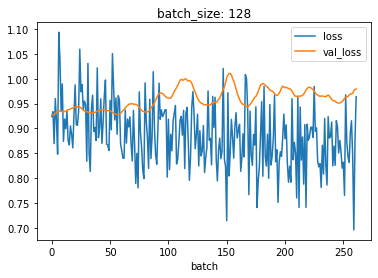

In [114]:
plt.plot([val['loss'] for val in batch_end_loss], label="loss")
plt.plot([val['val_loss'] for val in batch_end_loss], label="val_loss")
plt.xlabel("batch")
plt.title(f"batch_size: {batch_size}")
plt.legend()

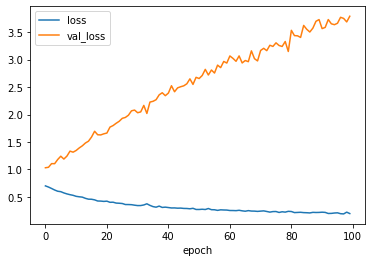

In [115]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.xlabel("epoch")
# plt.title(f"batch_size: {batch_size}")
plt.legend()